In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
from PIL import Image 

(CVXPY) Apr 11 10:42:54 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 11 10:42:54 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# Defining code to test metrics
def mse(image1, image2):
    squared_diff = (image1 - image2) ** 2
    mse = squared_diff.mean()
    return mse
def mad(image1, image2):
  diff = image1 - image2
  return np.mean(abs(diff))

In [3]:
X_full = mpl.pyplot.imread('face.jpeg') #loading image
X_full = X_full.mean(axis=2) #changing it to "grayscale"
X = spimg.zoom(X_full, 0.15) #downsizing image
height,width = X.shape #getting height and width of image

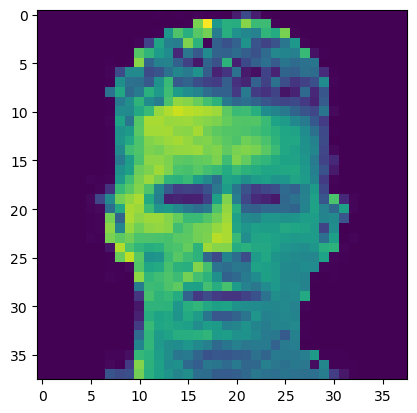

In [4]:
plt.imshow(X)

In [5]:
Y = np.fft.fft2(X) #take fourier transform

In [6]:
width, height = Y.shape

In [7]:
y = Y.flatten()

In [8]:
Yz = Y.copy()
Yz[np.abs(Yz) < 1000] = 0. #filter out values below a certain threshold

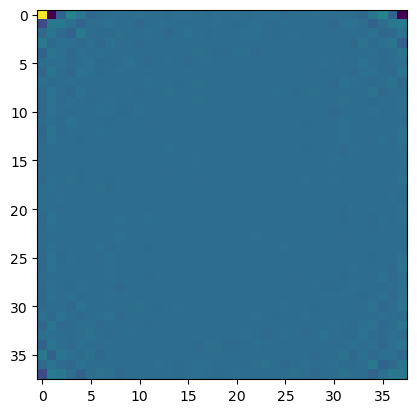

In [9]:
plt.imshow(Yz.real)

In [10]:
yz = Yz.flatten()

In [11]:
dim = yz.size

In [12]:
# Choosing samples from corners
square_size = 2
yul = Yz[:square_size, :square_size]
yur = Yz[:square_size, -square_size:]
yll = Yz[-square_size:, :square_size]
ylr = Yz[-square_size:, -square_size:]

corners = np.block([[yul, yur],
              [yll, ylr]])

In [13]:
corners_flat = corners.flatten()

In [14]:
# Stacking corners so we can sample from it later
stacked_corners = np.tile(corners_flat, 4)
stacked_corners = stacked_corners[:dim]
stacked_corners.shape

(64,)

In [15]:
num_rows_corners = stacked_corners.shape[0]
size_of_A = (dim//2)*dim

sampled_indices = np.random.randint(0, num_rows_corners, size=size_of_A)

# Create the new matrix by sampling rows from corners using the generated indices
A = stacked_corners[sampled_indices]
A = A.reshape(dim//2,dim)
yz = yz.reshape((-1, 1))


In [16]:
b = A@yz

In [17]:
# Doing optimization on real part
ysparsereal = cvx.Variable(dim)
ysparsereal = ysparsereal.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(ysparsereal, 1))
constraints = [cvx.norm(A@ysparsereal - b.real,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

/Users/Divya/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
# Doing optimization on imaginary part
ysparseimag = cvx.Variable(dim)
ysparseimag = ysparseimag.reshape((-1, 1))
obj = cvx.Minimize(cvx.norm(ysparseimag, 1))
constraints = [cvx.norm(A@ysparseimag - b.imag,2) <= 1e-8]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [ ]:
# Joining results together
ysparse = ysparsereal.value + ysparseimag.value*1j

In [ ]:
Ysparse = ysparse.reshape((width,height))

In [ ]:
# Reconstructing image
Xhat = np.fft.ifft2(Ysparse).real

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(Xhat)
plt.title('Reconstructed Image')

plt.show()

In [ ]:
norm_orig = X/255
norm_result = Xhat/255
print(mse(norm_orig, norm_result))
print(mse(X,Xhat))
print(mad(X, Xhat))